# 1. Modeling data preprocessing

In [1]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.fft import fft, fftfreq

## Dataset overview

I start this exercise by examining what data that I have been provided.

In [2]:
df_full = pd.read_parquet('../data/ml_dataset_full.parquet')
df_full.shape

(53700, 1009)

There are 53700 observations in total, and each observation has 1009 attributes.

In [3]:
df_full.iloc[:, :500].columns

Index(['voltage_0', 'voltage_1', 'voltage_2', 'voltage_3', 'voltage_4',
       'voltage_5', 'voltage_6', 'voltage_7', 'voltage_8', 'voltage_9',
       ...
       'voltage_490', 'voltage_491', 'voltage_492', 'voltage_493',
       'voltage_494', 'voltage_495', 'voltage_496', 'voltage_497',
       'voltage_498', 'voltage_499'],
      dtype='object', length=500)

500 of these attributes describe one voltage cycle at 50Hz AC, with a sampling rate of 25kHz (resulting in 500 samples).

In [4]:
df_full.iloc[:, 500:1000].columns

Index(['current_0', 'current_1', 'current_2', 'current_3', 'current_4',
       'current_5', 'current_6', 'current_7', 'current_8', 'current_9',
       ...
       'current_490', 'current_491', 'current_492', 'current_493',
       'current_494', 'current_495', 'current_496', 'current_497',
       'current_498', 'current_499'],
      dtype='object', length=500)

Another 500 describe one current cycle at 50Hz AC, with a sampling rate of 25kHz (again, 500 samples).

In [5]:
df_full.iloc[:, 1000:1006].columns

Index(['sensor_0', 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5'], dtype='object')

Six attributes represent six different sensors that can measure data such as temperature, humidity and air pressure. I do not know what these data are, but it may not be relevant for our purposes at this stage.

In [6]:
df_full.iloc[:, 1006:].columns

Index(['device_id', 'timestamp', 'label'], dtype='object')

The remaining three attributes are the device ID, timestamp and label.

The labels have been generated manually by an expert, and they can take the values 1, 2, 3 or 4. 1 represents the expected state of an asset, whereas 2-4 represent anomalies or uncertainties. If the observation hasn't been labelled, the label is empty.

In [7]:
df_full.label.value_counts(dropna=False)

NaN    48330
1.0     2110
3.0     1110
4.0     1100
2.0     1050
Name: label, dtype: int64

## Missing data

I investigate the missing data for the voltage, current, sensors and labels separately. The device IDs and timestamps are not relevant for this exercise, as they will not be used in the modeling.

In [8]:
df_voltage, df_current, df_sensors = df_full.iloc[:, :500], df_full.iloc[:, 500:1000], df_full.iloc[:, 1000:1006]

### Voltage

In [9]:
df_voltage.isnull().sum(axis=1).sort_values()

0          0
35748      0
35749      0
35750      0
35751      0
        ... 
9747     500
17131    500
39000    500
10383    500
45952    500
Length: 53700, dtype: int64

In [10]:
df_voltage.isnull().sum(axis=1).value_counts()

0      53432
500      268
dtype: int64

I can observe that there are 268 rows where the voltage cycle is completely missing. In all other cases, the cycle is completely present. As the voltage cycle most likely is crucial information in power distribution asset monitoring, it is a good idea to drop the row where this information is missing.

I drop these rows and regenerate all the dataframes.

In [11]:
df_cleansed = df_full[df_voltage.isnull().sum(axis=1) != 500].reset_index(drop=True)

In [12]:
df_cleansed.shape

(53432, 1009)

In [13]:
df_voltage, df_current, df_sensors = df_cleansed.iloc[:, :500], df_cleansed.iloc[:, 500:1000], df_cleansed.iloc[:, 1000:1006]

### Current

In [14]:
df_current.isnull().sum(axis=1).sort_values()

0          0
35485      0
35486      0
35487      0
35488      0
        ... 
4388     500
27085    500
23401    500
51713    500
17100    500
Length: 53432, dtype: int64

In [15]:
df_current.isnull().sum(axis=1).value_counts()

0      52631
500      801
dtype: int64

In the case of the current cycle, there are 801 observations where the information is completely missing. With the same reasoning as previously, I drop these from the dataset.

In [16]:
df_cleansed = df_cleansed[df_current.isnull().sum(axis=1) != 500].reset_index(drop=True)

In [17]:
df_cleansed.shape

(52631, 1009)

### Sensor data

In [18]:
df_sensors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53432 entries, 0 to 53431
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sensor_0  52898 non-null  float64
 1   sensor_1  50760 non-null  float64
 2   sensor_2  51831 non-null  float64
 3   sensor_3  52368 non-null  float64
 4   sensor_4  45410 non-null  float64
 5   sensor_5  48096 non-null  float64
dtypes: float64(6)
memory usage: 2.4 MB


The sensor data also seems to have its fair share of missing values. However, I are not certain which sensors, if any, are relevant for this exercise.

To get a quick understanding of what sensors to focus on, I can use boxplots to see what the relationship between the sensor data and the labels are.

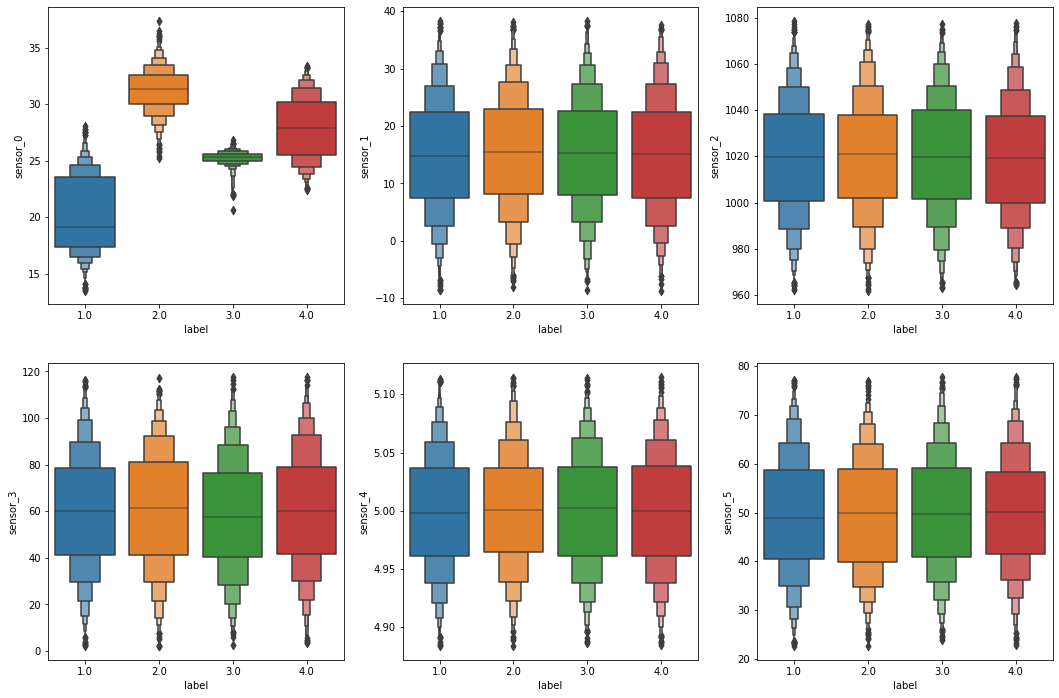

In [19]:
f = plt.figure(figsize=(18, 12))

dataframe = df_cleansed

ax1 = f.add_subplot(2, 3, 1)
ax1 = sns.boxenplot(x='label', y='sensor_0', data=dataframe)

ax2 = f.add_subplot(2, 3, 2)
ax2 = sns.boxenplot(x='label', y='sensor_1', data=dataframe)

ax3 = f.add_subplot(2, 3, 3)
ax3 = sns.boxenplot(x='label', y='sensor_2', data=dataframe)

ax4 = f.add_subplot(2, 3, 4)
ax4 = sns.boxenplot(x='label', y='sensor_3', data=dataframe)

ax5 = f.add_subplot(2, 3, 5)
ax5 = sns.boxenplot(x='label', y='sensor_4', data=dataframe)

ax6 = f.add_subplot(2, 3, 6)
ax6 = sns.boxenplot(x='label', y='sensor_5', data=dataframe)

plt.show()

Based on the figure above, sensors 1-5 do not seem to be very relevant in this case. However, sensor 0 definitely looks interesting. I therefore decide to only focus our efforts on sensor 0.

In [20]:
round(df_sensors.sensor_0.isna().sum() / df_sensors.sensor_0.count(), 3)

0.01

I could try to infer the missing data for sensor 0 using e.g. the mean, median or clustering, but 99% of the rows have data, I drop the rows with missing data to save some time.

In [21]:
df_cleansed = df_cleansed[~df_sensors.sensor_0.isna()].reset_index(drop=True)

<ipython-input-21-a2a3fb6430b5>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_cleansed = df_cleansed[~df_sensors.sensor_0.isna()].reset_index(drop=True)


In [22]:
df_cleansed.shape

(52102, 1009)

### Missing data - summary

I started out with 53700 observations. After cleansing the missing data, I ended up with 52102 observations.

## Preprocessing

To investigate what information the voltage and current data holds in regards to the labels, I explore the data visually. I will first do it for the voltage, and then move on to the current.

As a first step, I align the cycles for the different observations. I will do this by determining the highest point in the cycle, and shifting that to the beginning. To make sure that I don't tamper with the data, I carry out this shift based on the highest point of the voltage data.

In [23]:
voltage, current = df_cleansed.iloc[:, :500], df_cleansed.iloc[:, 500:1000]

for i in range(len(voltage)):
    shift = np.argmax(voltage.iloc[i])
    voltage.iloc[i] = np.roll(voltage.iloc[i], -shift)
    current.iloc[i] = np.roll(current.iloc[i], -shift)

df_cleansed.iloc[:, :500] = voltage
df_cleansed.iloc[:, 500:1000] = current

I plot the voltage and current cycles based on the label to see if there are any patterns that I can directly observe.

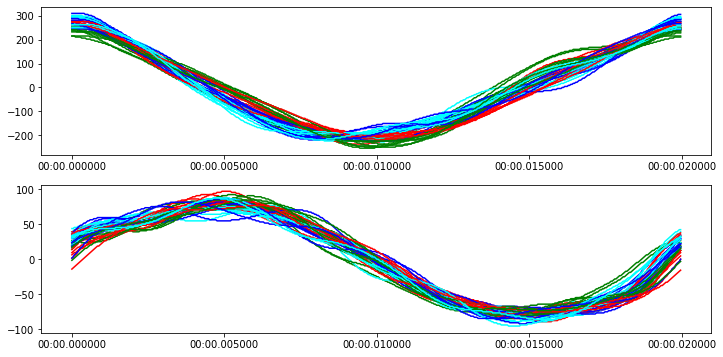

In [24]:
f = plt.figure(figsize=(12, 6))
ax1 = f.add_subplot(2, 1, 1)
ax2 = f.add_subplot(2, 1, 2)

r = 10
dataset = df_cleansed

for i in range(r):
    for label in [1, 2, 3, 4]:
        df_plot = dataset[dataset.label == label].reset_index(drop=True)
        voltage, current = df_plot.iloc[i, :500].astype(float), df_plot.iloc[i, 500:1000].astype(float)
        
        shift = np.argmax(voltage)
        voltage = np.roll(voltage, (-1) * shift)
        current = np.roll(current, (-1) * shift)
        
        start = datetime.datetime(2000, 1, 1)
        timestamp = np.arange(start, start + datetime.timedelta(microseconds=40 * 500), datetime.timedelta(microseconds=40))
        
        if label == 1:
            ax1.plot(timestamp, voltage, c='red')
            ax2.plot(timestamp, current, c='red')
        if label == 2:
            ax1.plot(timestamp, voltage, c='blue')
            ax2.plot(timestamp, current, c='blue')
        if label == 3:
            ax1.plot(timestamp, voltage, c='green')
            ax2.plot(timestamp, current, c='green')
        if label == 4:
            ax1.plot(timestamp, voltage, c='cyan')
            ax2.plot(timestamp, current, c='cyan')

plt.show()

I can observe that at least for the voltage (i.e. the upper plot), there seems to be some clear groupings for the different labels. This investigation is therefore worthwhile.

### Voltage

I start by applying the Fourier Transform to the voltage data.

__NB!__ I have not done this before and my approach may be completely wrong. In a real world situation, I would investigate this further. However, to avoid using too much time on this, I will assume that what I do here is correct.

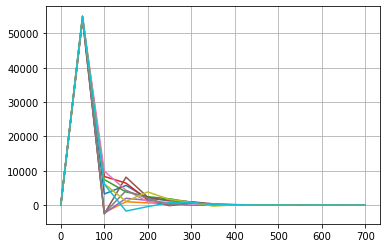

In [25]:
samples = 500
sampling_rate = 1 / 25000

voltage = df_cleansed.iloc[:, :500]

voltage_ft_array = np.real(fft(voltage)[:, :samples // 2])
voltage_ft_frequencies = fftfreq(samples, sampling_rate)[:samples // 2].astype(int)

for i in range(10):
    plt.plot(voltage_ft_frequencies[:15], voltage_ft_array[i, :15])
plt.grid()
plt.show()

In [26]:
df_voltage_ft = pd.DataFrame(voltage_ft_array, columns=[f'voltage_freq_{i}' for i in voltage_ft_frequencies])

In [27]:
df_voltage_ft.head()

,voltage_freq_0,voltage_freq_50,voltage_freq_100,voltage_freq_150,voltage_freq_200,voltage_freq_250,voltage_freq_300,voltage_freq_350,voltage_freq_400,voltage_freq_450,...,voltage_freq_12000,voltage_freq_12050,voltage_freq_12100,voltage_freq_12150,voltage_freq_12200,voltage_freq_12250,voltage_freq_12300,voltage_freq_12350,voltage_freq_12400,voltage_freq_12450
0,2.583170e+01,54979.629378,3252.048729,5759.430594,1992.341701,1354.514612,942.559935,22.420273,107.104420,55.408021,...,2.992866,4.768221,-7.960448,-20.520627,-12.819486,3.064536,23.116571,2.905783,-9.429532,5.152572
1,4.305284e+00,54577.588456,-2128.635770,998.084157,662.772154,432.497630,759.057486,57.055916,122.596048,44.185507,...,-4.844846,-14.891980,-39.947371,28.517844,27.928106,-10.933384,20.467670,25.537678,-1.476276,-30.935727
2,-3.268497e-13,54025.363500,7452.666192,3859.266821,2459.584176,1850.780097,848.227943,110.632128,-10.868977,26.164761,...,-19.984932,-7.190423,2.251558,6.336933,-7.273792,-14.440463,13.614307,3.293953,-26.598355,10.726940
3,-3.013699e+01,54488.214991,8348.201652,6419.041553,1505.236586,-143.391116,651.706550,227.486341,45.228335,46.586828,...,-1.595952,-28.092626,-1.357323,28.054290,-12.234806,-7.418649,48.294013,42.716526,-8.140394,24.185418
4,4.735812e+01,54024.825798,-2397.839620,2010.023868,1399.423102,396.574185,-10.441925,-7.303654,80.280474,46.435173,...,-13.245994,-14.033404,-6.895468,14.176382,17.020733,16.740725,-22.962963,-3.198128,23.488206,-13.627911


In [28]:
df_voltage_ft.describe()

,voltage_freq_0,voltage_freq_50,voltage_freq_100,voltage_freq_150,voltage_freq_200,voltage_freq_250,voltage_freq_300,voltage_freq_350,voltage_freq_400,voltage_freq_450,...,voltage_freq_12000,voltage_freq_12050,voltage_freq_12100,voltage_freq_12150,voltage_freq_12200,voltage_freq_12250,voltage_freq_12300,voltage_freq_12350,voltage_freq_12400,voltage_freq_12450
count,5.210200e+04,52102.000000,52102.000000,52102.000000,52102.000000,52102.000000,52102.000000,52102.000000,52102.000000,52102.000000,...,52102.000000,52102.000000,52102.000000,52102.000000,52102.000000,52102.000000,52102.000000,52102.000000,52102.000000,52102.000000
mean,-1.479110e-02,54634.458233,4445.947443,3602.674886,2034.552292,988.346389,442.842788,189.311237,78.108795,31.738407,...,2.146372,2.294734,2.401931,2.211995,2.340333,2.274012,2.305061,2.190940,2.348181,2.362521
std,2.238037e+01,396.162765,4202.804700,2686.754075,1495.524193,739.096609,342.876997,154.247720,68.768833,32.664981,...,23.412118,23.359334,23.243442,22.937460,23.099218,23.101745,23.077919,22.922368,22.944250,21.463949
min,-1.205479e+02,49150.110039,-3025.068073,-7332.865390,-4109.871837,-2039.791070,-1212.212526,-486.481558,-230.351748,-106.597082,...,-106.108923,-107.178334,-108.702152,-96.839845,-107.264831,-102.398548,-108.362783,-115.681403,-107.581967,-96.107539
25%,-1.291585e+01,54474.900197,1851.381837,1777.198588,1034.583864,490.245662,210.551792,86.826909,32.153257,9.929939,...,-13.442932,-13.191332,-12.906001,-13.068713,-12.990746,-12.942253,-12.857611,-12.956882,-12.782605,-11.863734
50%,7.105427e-14,54755.121271,5279.808293,3580.539242,2036.300161,989.081128,444.139223,190.279862,79.162251,32.176754,...,2.259883,2.461500,2.481396,2.219456,2.238244,2.249155,2.261056,2.188975,2.195684,2.415644
75%,1.291585e+01,54927.918759,7827.653988,5410.338140,3041.306238,1489.240105,676.283560,294.177193,124.651410,53.611118,...,17.625363,17.833290,17.779703,17.517332,17.420968,17.422618,17.602411,17.301438,17.404103,16.690559
max,1.119374e+02,55076.024788,13450.328370,15022.478662,8183.511576,4260.679444,1853.439697,770.291870,363.231203,181.854040,...,105.564286,104.814179,100.166693,119.639455,96.437658,103.008037,135.547349,121.232030,121.618289,97.426715


I investigate what the relationship is between the Fourer Transformed voltage readings and the labels. I do this only for the first few frequencies, as the observations tend to zero when the frequency increases.

In [29]:
df_voltage_ft_labeled = df_voltage_ft.join(df_cleansed[['label']]).dropna()

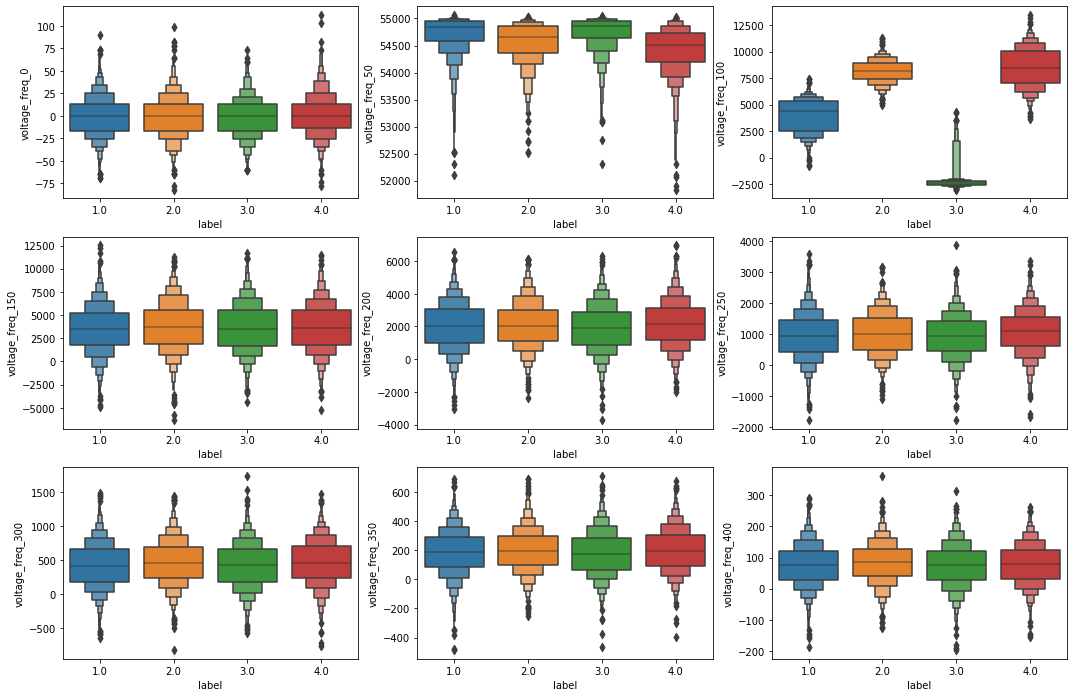

In [30]:
f = plt.figure(figsize=(18, 12))

dataframe = df_voltage_ft_labeled

ax1 = f.add_subplot(3, 3, 1)
ax1 = sns.boxenplot(x='label', y='voltage_freq_0', data=dataframe)

ax2 = f.add_subplot(3, 3, 2)
ax2 = sns.boxenplot(x='label', y='voltage_freq_50', data=dataframe)

ax3 = f.add_subplot(3, 3, 3)
ax3 = sns.boxenplot(x='label', y='voltage_freq_100', data=dataframe)

ax4 = f.add_subplot(3, 3, 4)
ax4 = sns.boxenplot(x='label', y='voltage_freq_150', data=dataframe)

ax5 = f.add_subplot(3, 3, 5)
ax5 = sns.boxenplot(x='label', y='voltage_freq_200', data=dataframe)

ax6 = f.add_subplot(3, 3, 6)
ax6 = sns.boxenplot(x='label', y='voltage_freq_250', data=dataframe)

ax7 = f.add_subplot(3, 3, 7)
ax7 = sns.boxenplot(x='label', y='voltage_freq_300', data=dataframe)

ax8 = f.add_subplot(3, 3, 8)
ax8 = sns.boxenplot(x='label', y='voltage_freq_350', data=dataframe)

ax9 = f.add_subplot(3, 3, 9)
ax9 = sns.boxenplot(x='label', y='voltage_freq_400', data=dataframe)

plt.show()

I see that the voltage_freq_100 variable definitely seems to hold some interesting information. I will therefore include that in the investigation.

The other frequencies do not seem to hold any information of relevance for our investigation, so I will not use them further.

### Current

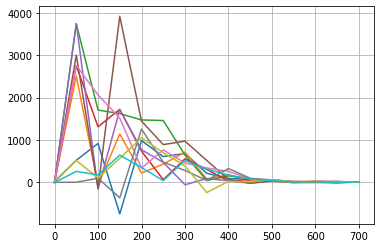

In [31]:
samples = 500
sampling_rate = 1 / 25000

current = df_cleansed.iloc[:, 500:1000]

current_ft_array = np.real(fft(current)[:, :samples // 2])
current_ft_frequencies = fftfreq(samples, sampling_rate)[:samples // 2].astype(int)

for i in range(10):
    plt.plot(current_ft_frequencies[:15], current_ft_array[i, :15])
plt.grid()
plt.show()

In [32]:
df_current_ft = pd.DataFrame(current_ft_array, columns=[f'current_freq_{i}' for i in current_ft_frequencies])

In [33]:
df_current_ft.head()

,current_freq_0,current_freq_50,current_freq_100,current_freq_150,current_freq_200,current_freq_250,current_freq_300,current_freq_350,current_freq_400,current_freq_450,...,current_freq_12000,current_freq_12050,current_freq_12100,current_freq_12150,current_freq_12200,current_freq_12250,current_freq_12300,current_freq_12350,current_freq_12400,current_freq_12450
0,14.090020,516.200228,913.682622,-754.319064,982.500899,602.641794,677.216237,208.529522,83.050068,71.005402,...,-6.808419,-3.819515,-3.357046,4.970053,-3.923361,9.993487,-8.805776,14.625774,3.239973,-7.668583
1,4.696673,2510.892530,-70.144148,1136.940336,212.463610,426.429743,708.716015,74.922241,174.345771,27.943256,...,2.238809,1.410275,-11.871844,-6.967489,0.479026,-5.498798,-5.488078,4.433788,1.573182,-10.704853
2,1.565558,3750.525426,1705.408684,1620.730751,1470.967822,1457.527199,639.840509,35.625334,146.931653,81.934781,...,-1.320675,7.618338,8.618387,-9.888241,2.491281,2.886496,1.619922,-3.020058,1.336626,-0.855225
3,-7.827789,2755.585174,1308.747909,1722.490446,731.632452,56.961163,550.386734,300.257540,24.561028,62.766904,...,12.171662,-3.130078,-11.805834,-2.680851,-7.147712,-4.298710,2.701569,-6.478257,3.685205,2.715575
4,-10.958904,3755.709244,-165.533040,1715.592375,765.091006,466.623828,-63.649731,83.086100,31.926465,-28.719805,...,-2.310603,-0.883833,5.319632,2.371456,-4.073660,-7.779435,5.486721,10.696754,11.033074,-6.922456


In [34]:
df_current_ft.describe()

,current_freq_0,current_freq_50,current_freq_100,current_freq_150,current_freq_200,current_freq_250,current_freq_300,current_freq_350,current_freq_400,current_freq_450,...,current_freq_12000,current_freq_12050,current_freq_12100,current_freq_12150,current_freq_12200,current_freq_12250,current_freq_12300,current_freq_12350,current_freq_12400,current_freq_12450
count,5.210200e+04,52102.000000,52102.000000,52102.000000,52102.000000,52102.000000,52102.000000,52102.000000,52102.000000,52102.000000,...,52102.000000,52102.000000,52102.000000,52102.000000,52102.000000,52102.000000,52102.000000,52102.000000,52102.000000,52102.000000
mean,4.374980e-02,1792.959963,805.442424,1151.607948,975.764172,652.853239,380.846000,202.366665,99.324655,45.664449,...,-0.052837,0.031709,-0.007258,0.032676,-0.018673,0.011828,-0.054609,0.031450,-0.049799,-0.002011
std,9.829715e+00,1436.845922,799.912893,1083.508012,894.917192,581.638418,330.746047,174.998716,88.657457,43.587576,...,7.298211,7.295141,7.335597,7.239811,7.264372,7.337163,7.417715,7.430060,6.857495,7.836334
min,-4.540117e+01,-8965.695393,-620.600720,-3192.985665,-2777.208555,-2249.499444,-1093.610930,-508.013900,-293.148567,-154.790823,...,-28.356758,-31.040688,-30.513200,-32.592325,-41.379243,-35.179786,-34.592882,-36.158807,-29.519859,-38.153970
25%,-6.262231e+00,986.890026,-7.860276,422.944550,381.510612,262.999379,162.070687,84.930379,41.018616,16.761175,...,-4.928077,-4.787675,-4.919032,-4.815959,-4.908855,-4.888037,-4.932157,-4.887542,-4.594132,-5.151369
50%,2.131628e-14,1763.981332,756.285018,1165.132004,985.603552,659.273862,383.803502,203.416461,99.846848,46.280218,...,-0.068454,0.015522,-0.015033,0.027512,0.009390,0.033296,-0.028594,0.052836,-0.055337,0.024458
75%,6.262231e+00,2755.993799,1580.363915,1888.699905,1585.257267,1048.805238,604.543423,320.414370,159.215358,75.110828,...,4.825771,4.862122,4.900877,4.811640,4.817240,4.953760,4.860397,4.960788,4.478594,5.169570
max,4.383562e+01,8523.255523,2562.832018,5644.176460,4484.773688,3200.154358,1740.531364,935.984829,459.470673,225.937238,...,32.027370,31.374667,42.696449,32.467692,35.160795,35.782874,35.162789,38.907844,32.036842,38.314034


In [35]:
df_current_ft_labeled = df_current_ft.join(df_cleansed[['label']]).dropna()

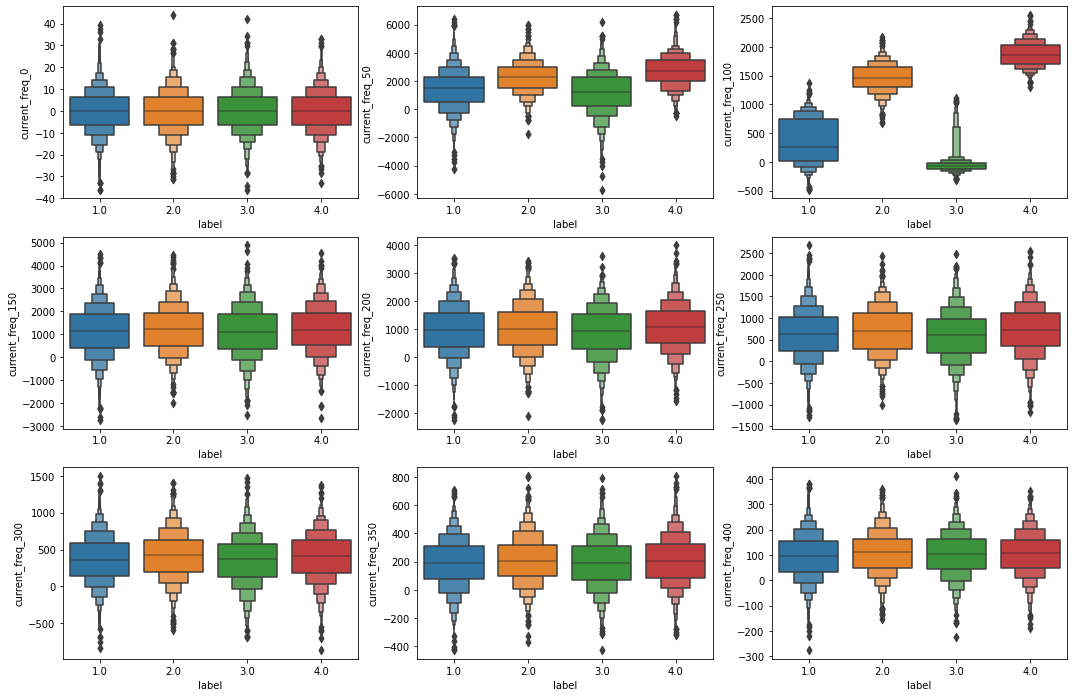

In [36]:
f = plt.figure(figsize=(18, 12))

dataframe = df_current_ft_labeled

ax1 = f.add_subplot(3, 3, 1)
ax1 = sns.boxenplot(x='label', y='current_freq_0', data=dataframe)

ax2 = f.add_subplot(3, 3, 2)
ax2 = sns.boxenplot(x='label', y='current_freq_50', data=dataframe)

ax3 = f.add_subplot(3, 3, 3)
ax3 = sns.boxenplot(x='label', y='current_freq_100', data=dataframe)

ax4 = f.add_subplot(3, 3, 4)
ax4 = sns.boxenplot(x='label', y='current_freq_150', data=dataframe)

ax5 = f.add_subplot(3, 3, 5)
ax5 = sns.boxenplot(x='label', y='current_freq_200', data=dataframe)

ax6 = f.add_subplot(3, 3, 6)
ax6 = sns.boxenplot(x='label', y='current_freq_250', data=dataframe)

ax7 = f.add_subplot(3, 3, 7)
ax7 = sns.boxenplot(x='label', y='current_freq_300', data=dataframe)

ax8 = f.add_subplot(3, 3, 8)
ax8 = sns.boxenplot(x='label', y='current_freq_350', data=dataframe)

ax9 = f.add_subplot(3, 3, 9)
ax9 = sns.boxenplot(x='label', y='current_freq_400', data=dataframe)

plt.show()

In the case of the current, it looks like current_freq_100 is the most promising feature. current_freq_50 also seems to hold some information. I therefore include both of these in our further investiations and drop the rest of the data.

## Exporting preprocessed data

In [37]:
# Join the data
df_out = df_voltage_ft[['voltage_freq_100']] \
    .join(df_current_ft[['current_freq_50', 'current_freq_100']], how='inner') \
    .join(df_cleansed[['sensor_0', 'device_id', 'timestamp', 'label']], how='inner')

# Rearrange columns
df_out = df_out[['timestamp', 'device_id', 'voltage_freq_100', 'current_freq_50', 'current_freq_100', 'sensor_0', 'label']]

# Drop rows where sensor_0 data is missing
df_out = df_out.dropna(subset=['sensor_0']).reset_index(drop=True)

In [38]:
df_out.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51577 entries, 0 to 51576
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   timestamp         51577 non-null  datetime64[ns]
 1   device_id         51577 non-null  object        
 2   voltage_freq_100  51577 non-null  float64       
 3   current_freq_50   51577 non-null  float64       
 4   current_freq_100  51577 non-null  float64       
 5   sensor_0          51577 non-null  float64       
 6   label             5151 non-null   float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 2.8+ MB


I export the preprocessed data to a new parquet file.

In [39]:
df_out.to_parquet('../data/ml_dataset_preprocessed.parquet', compression='gzip')